##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Tuning Quickstart with Python

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Tuning.ipynb"><img src="https://github.com/google-gemini/cookbook/blob/main/images/colab_logo_32px.png?raw=1" />Run in Google Colab</a>
  </td>
</table>

In this notebook, you'll learn how to get started with model tuning.

## What is model tuning?

Prompt design strategies such as few shot prompting may not always produce the results you need. Use model tuning to improve a model's performance on specific tasks or help the model adhere to specific output requirements when instructions aren't sufficient and you have a set of examples that demonstrate the outputs you want.

The goal of model tuning is to further improve the performance of the model for your specific task. Model tuning works by providing the model with a training dataset containing many examples of the task. For niche tasks, you can get significant improvements in model performance by tuning the model on a modest number of examples.

Your training data should be structured as examples with prompt inputs and expected response outputs. The goal is to teach the model to mimic the wanted behavior or task, by giving it many examples illustrating that behavior or task.

You can also tune models using example data directly in Google AI Studio.

## Setup

In [2]:
!pip install -q -U "google-generativeai>=0.7.2"

In [3]:
import google.generativeai as genai

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [4]:
from google.colab import userdata
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

You can check your existing tuned models with the `genai.list_tuned_model` method.

In [5]:
for m in genai.list_tuned_models():
  print(m.name)

tunedModels/generate-num-4451


## Prepare your dataset

Before you can start fine-tuning, you need a dataset to tune the model with. For the best performance, the examples in the dataset should be of high quality, diverse, and representative of real inputs and outputs.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

Dataset for tuning the model can be one of the following types:
1. `Iterable` of dicts or tuples.
2. `Mapping` of `Iterable[str]`.
3. CSV file.
4. JSON file.

To know more about preparing a dataset for fine-tuning visit [model-tuning documentation](https://ai.google.dev/gemini-api/docs/model-tuning#prepare-dataset).

Note: In general, you need between 100 and 500 examples to significantly change the behavior of the model.

The following sections illustrate how to provide the dataset as an `Iterable` or a CSV file.

### Training data as an `Iterable`

Data can be an `Iterable` of:
* `{'text_input': text_input, 'output': output}` dicts
* `(text_input, output)` tuples.

In [6]:
# Provide data as a list of dicts

dict_data =[
    {
          'text_input': '1',
          'output': '2',
    },{
          'text_input': '3',
          'output': '4',
    },{
          'text_input': '-3',
          'output': '-2',
    },{
          'text_input': 'twenty two',
          'output': 'twenty three',
    },{
          'text_input': 'two hundred',
          'output': 'two hundred one',
    },{
          'text_input': 'ninety nine',
          'output': 'one hundred',
    },{
          'text_input': '8',
          'output': '9',
    },{
          'text_input': '-98',
          'output': '-97',
    },{
          'text_input': '1,000',
          'output': '1,001',
    },{
          'text_input': '10,100,000',
          'output': '10,100,001',
    },{
          'text_input': 'thirteen',
          'output': 'fourteen',
    },{
          'text_input': 'eighty',
          'output': 'eighty one',
    },{
          'text_input': 'one',
          'output': 'two',
    },{
          'text_input': 'three',
          'output': 'four',
    },{
          'text_input': 'seven',
          'output': 'eight',
    }
]

### Training data as a CSV file

You can provide your CSV file to the tuning API in one of the following ways:
  * A path of type `str` or `pathlib.Path` to a local CSV file.
  * A URL to the CSV file.
  * The public URL of a Google Sheets file.

For this example, you will provide the path to a local CSV file containing the training dataset as `pathlib.Path` to the tuning API.


Run the following cell to create the CSV file, `data.csv`.
The CSV file has the default columns, `text_input` for the input and `output` for the output.


In [7]:
%%writefile data.csv
text_input,output
1,2
3,4
-3,-2
twenty two,twenty three
two hundred,two hundred one
ninety nine,one hundred
8,9
-98,-97
"1,000","1,001"
"1,01,00,000","1,01,00,001"
thirteen,fourteen
eighty,eighty one
one,two
three,four
seven,eight

Writing data.csv


If your CSV file doesn't have the default field names, you can mention your input and output field directly in the `create_tuned_model` function.

```
create_tuned_model(
    training_data = <csv file path>,
    ...
    input_key= <input field name>,
    output_key = <output field name>
)
```

Get the CSV file path as a `pathlib.Path` object.

In [8]:
import pathlib

# Provide data as a CSV file `pathlib.Path` object.
csv_file=pathlib.Path('data.csv')

### Pass your dataset as training data

In [9]:
# Here you can specify any of the supported formats, e.g. dict_data or csv_file.
train_data = dict_data

## Create tuned model

Get the list of models available for tuning.


In [10]:
tunable_models = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods]
tunable_models  # ['models/gemini-1.0-pro-001', 'models/gemini-1.5-flash-001-tuning']

[Model(name='models/gemini-1.0-pro-001',
       base_model_id='',
       version='001',
       display_name='Gemini 1.0 Pro 001 (Tuning)',
       description=('The original Gemini 1.0 Pro model version that supports tuning. Gemini 1.0 '
                    'Pro will be discontinued on February 15th, 2025. Move to a newer Gemini '
                    'version.'),
       input_token_limit=30720,
       output_token_limit=2048,
       supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
       temperature=0.9,
       max_temperature=None,
       top_p=1.0,
       top_k=None),
 Model(name='models/gemini-1.5-flash-001-tuning',
       base_model_id='',
       version='001',
       display_name='Gemini 1.5 Flash 001 Tuning',
       description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                    'multimodal model for scaling across diverse tasks, released in May of 2024.'),
       input_token_limit=16384,
       outpu

Select the source model for tuning.


In [11]:
base_model = [m for m in tunable_models if 'flash' in m.name][-1]  # models/gemini-1.5-flash-001-tuning
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                   'multimodal model for scaling across diverse tasks, released in May of 2024.'),
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

To create a tuned model, you need to pass the dataset you prepared earlier to  `genai.create_tuned_model` method.

In [12]:
import random

name = f'generate-num-{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model=base_model.name,
    # Pass the dataset created earlier.
    training_data=train_data,
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [13]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/generate-num-9151',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2024, 12, 6, 6, 57, 8, 323179, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 12, 6, 6, 57, 8, 323179, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 12, 6, 6, 57, 8, 592647, tzinfo=datetime.timezone.utc),
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batch_size=4,
                                                                  le

In [14]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [15]:
operation.metadata

tuned_model: "tunedModels/generate-num-9151"
total_steps: 375

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [16]:
import time

for n,status in enumerate(operation.wait_bar()):
  if n%100 == 0:
    print()
  print('.', end='')
  time.sleep(10)

  0%|          | 0/375 [00:00<?, ?it/s]


..............................................................................

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [17]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://generativeai.devsite.corp.google.com/guide/model_tuning_guidance#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

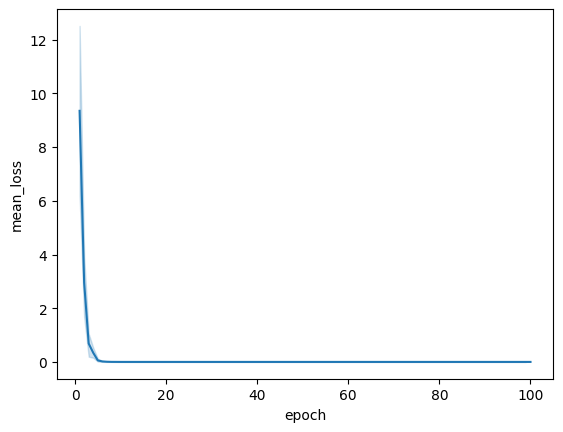

In [18]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_text` method and specify the name of your model to test your model performance.

In [19]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')

In [20]:
result = model.generate_content('55')
result.text

'56'

In [21]:
result = model.generate_content('123455')
result.text

'123'

In [22]:
result = model.generate_content('four')
result.text

'five'

In [23]:
result = model.generate_content('quatre') # French 4
result.text                               # French 5 is "cinq"

'cinq'

In [24]:
result = model.generate_content('III')    # Roman numeral 3
result.text                               # Roman numeral 4 is IV

'IV'

In [25]:
result = model.generate_content('七')  # Japanese 7
result.text                            # Japanese 8 is 八!

'八'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/docs/model_tuning_guidance) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [26]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is my model."});

In [27]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [28]:
genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [29]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 GET https://generativelanguage.googleapis.com/v1beta/tunedModels/generate-num-9151?%24alt=json%3Benum-encoding%3Dint: Tuned model tunedModels/generate-num-9151 does not exist.
